In [84]:
import multiprocessing
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def XGBRegressorForSurveyFast (df, test, emotion ,testRatio = 0.2, learning_rate = 0.1, max_depth = 5, colsample_bytree = 0.3,
                           subsample = 0.8):
    """predict whether the surveyee will be craving given the survey
    
    Args: 
        df (pd.DataFrame): the data set we need for the training and test data
        emotion (str): the emotion we are going to predict
        testRatio (float) : ratio of the test data in the whole dataset
        learning_rate (float): learning rate of XGB model, range [0, 1]. Defaults to 0.1
        max_depth (int): maximum depth of tree. Defaults to 5
        colsample_bytree (float): fraction of columns to be randomly sampled for each tree. Defaults to 0.3
        subsample (float): fraction of observations to be randomly sampled for each tree. Defaults to 0.8     
    """  
    
    # delete uneccessary columns
    emotionList = ['relaxed', 'happy', 'stressed', 'tired', 'anxious','sad'] 
    emotionList.remove(emotion)
    dropList = emotionList + ['ts', '_window_end']
    df = df.drop(dropList, axis=1)
    
    # get the name of columns for features
    new_cols = [col for col in df.columns if col != emotion] + [emotion]
    df = df[new_cols]
    test = test[new_cols]
    feature_columns = new_cols[:-1]

    # Isolate the x and y variables
    y = df.iloc[:, -1].values
    X = df.iloc[:, :-1].values
    
    test_y = test.iloc[:, -1].values
    test_X = test.iloc[:, :-1].values
    
    
    # Create xgboost matrices
    Train = xgb.DMatrix(X, label = y, feature_names = feature_columns)
    Test = xgb.DMatrix(test_X, label = test_y, feature_names = feature_columns)
    
    finalParameters = {'learning_rate': learning_rate,
                       'max_depth': max_depth,
                       'colsample_bytree': colsample_bytree,
                       'subsample': subsample,
                       'eval_metric': "rmse",
                       'objective': "reg:squarederror"}
    
    finalModel = xgb.train(params = finalParameters,
                   dtrain = Train,
                   num_boost_round = 800,
                   early_stopping_rounds= 25,
                   evals = [(Test, "Yes")],
                   verbose_eval = 50)
    
    # Predictions on test dataset
    preds = finalModel.predict(Test)
    
    # plot pred and pred-actual
    fig, ax = plt.subplots(2, 1, figsize=(8,8))
    ax[0].hist(preds, bins = 50);
    ax[1].hist(preds - test_y, bins = 50);
    ax[0].set_title('pred')
    ax[1].set_title('pred - actual');

    plt.show()
    
    # show results
    rmse = np.sqrt(mean_squared_error(test_y, preds))
    print("RMSE: %f" % (rmse))
    
    
    # plot feature importances
    xgb.plot_importance(finalModel, max_num_features = 10)
    plt.rcParams['figure.figsize'] = [5, 5]
    plt.show()
    
    # plot true val vs. predictions
    true_val = test[emotion].values
    plt.plot(true_val)
    plt.plot(preds)
    plt.title("true val vs. predictions")
    plt.show()
    
    

In [85]:
df1 = pd.read_csv('./data/agg_data89_p1.csv')
df2 = pd.read_csv('./data/agg_data89_p2.csv')
df3 = pd.read_csv('./data/agg_data89_p3.csv')
train = pd.concat([df1, df2, df3])
train

,acc_x,acc_y,acc_z,bvp,conductance,heartrate,temperature,relaxed,happy,stressed,...,acc_y_1h__std,acc_z_1h__std,bvp_1h__mean,bvp_1h__std,conductance_1h__mean,conductance_1h__std,heartrate_1h__mean,heartrate_1h__std,temperature_1h__mean,temperature_1h__std
0,-52.0,16.0,32.0,-82.890000,0.064067,90.83,32.09,6.0,6.0,7.0,...,21.021027,16.856616,-0.064779,159.879953,0.125697,0.040253,85.219254,9.456966,31.500535,0.392482
1,-52.0,19.0,32.0,26.030000,0.043565,107.32,31.97,6.0,6.0,7.0,...,21.021027,16.856616,-0.064779,159.879953,0.125697,0.040253,85.219254,9.456966,31.500535,0.392482
2,-27.0,19.0,15.0,58.420000,0.066629,104.15,31.85,6.0,6.0,7.0,...,21.021027,16.856616,-0.064779,159.879953,0.125697,0.040253,85.219254,9.456966,31.500535,0.392482
3,-50.0,23.0,32.0,-5.780000,0.123008,77.87,31.75,6.0,6.0,7.0,...,21.021027,16.856616,-0.064779,159.879953,0.125697,0.040253,85.219254,9.456966,31.500535,0.392482
4,-62.0,-31.0,-19.0,-93.593333,0.129414,80.60,31.85,6.0,6.0,7.0,...,21.021027,16.856616,-0.064779,159.879953,0.125697,0.040253,85.219254,9.456966,31.500535,0.392482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9113,48.0,-35.0,29.0,-41.083333,0.005126,113.97,33.77,6.0,5.0,3.0,...,27.270473,23.507425,-0.008285,174.513723,0.048418,0.041553,94.727345,15.023970,32.490968,0.620241
9114,11.0,-71.0,4.0,81.260000,0.007688,99.35,33.91,6.0,5.0,3.0,...,27.270473,23.507425,-0.008285,174.513723,0.048418,0.041553,94.727345,15.023970,32.490968,0.620241
9115,27.0,-46.0,60.0,-69.630000,0.006407,96.02,34.03,6.0,5.0,3.0,...,27.270473,23.507425,-0.008285,174.513723,0.048418,0.041553,94.727345,15.023970,32.490968,0.620241
9116,35.0,1.0,59.0,47.960000,0.084573,104.93,33.71,6.0,5.0,3.0,...,27.270473,23.507425,-0.008285,174.513723,0.048418,0.041553,94.727345,15.023970,32.490968,0.620241


In [86]:
test = pd.read_csv('./data/agg_data89_p4.csv')

[0]	Yes-rmse:3.52102
[50]	Yes-rmse:1.46959
[55]	Yes-rmse:1.47339


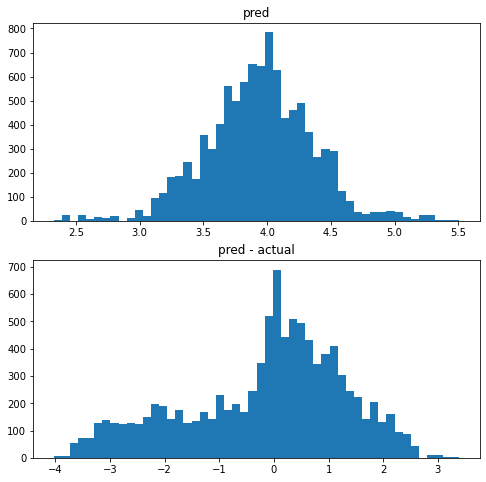

RMSE: 1.471286


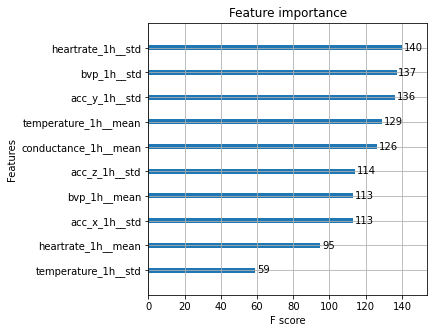

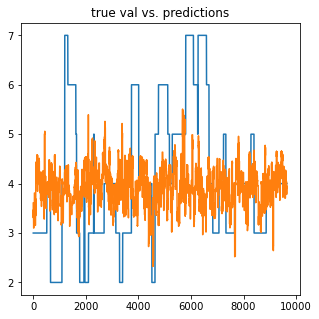

In [87]:
XGBRegressorForSurveyFast(train, test, "stressed" ,testRatio = 0.2)

[0]	Yes-rmse:5.04193
[50]	Yes-rmse:0.94328
[70]	Yes-rmse:0.94795


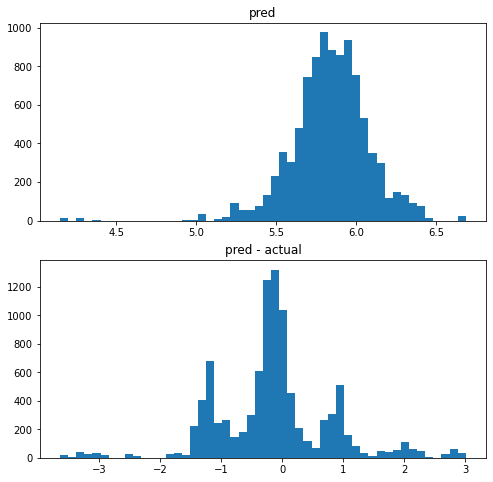

RMSE: 0.947951


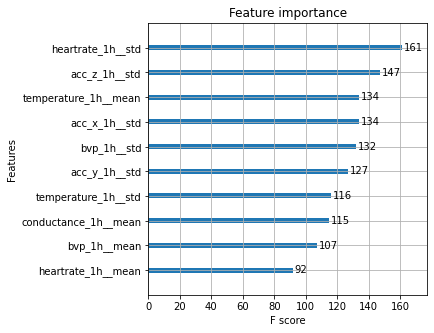

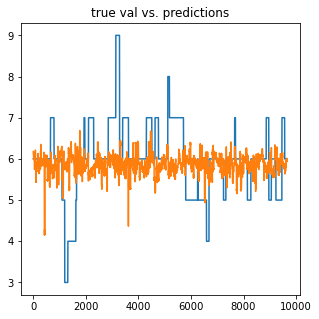

In [88]:
XGBRegressorForSurveyFast(train, test, 'happy' ,testRatio = 0.2)

[0]	Yes-rmse:4.43824
[50]	Yes-rmse:1.17302
[54]	Yes-rmse:1.17702


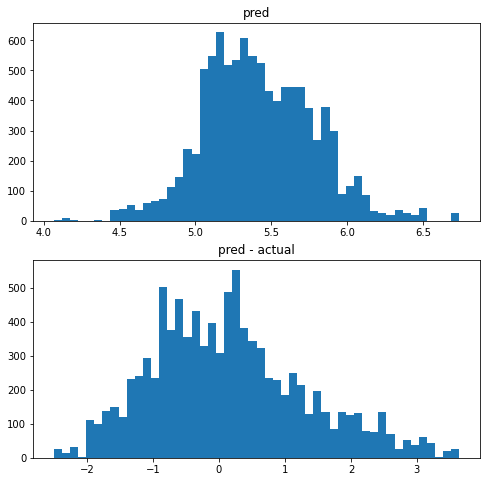

RMSE: 1.177021


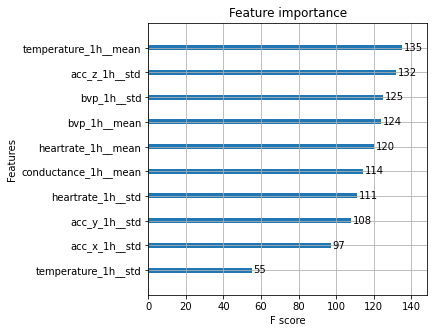

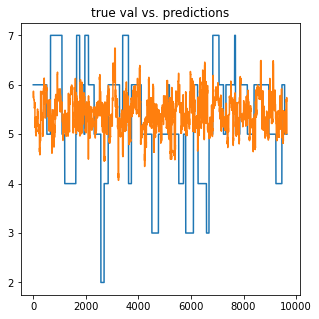

In [89]:
XGBRegressorForSurveyFast(train, test, 'relaxed' ,testRatio = 0.2)

[0]	Yes-rmse:4.59205
[50]	Yes-rmse:1.90148
[58]	Yes-rmse:1.91271


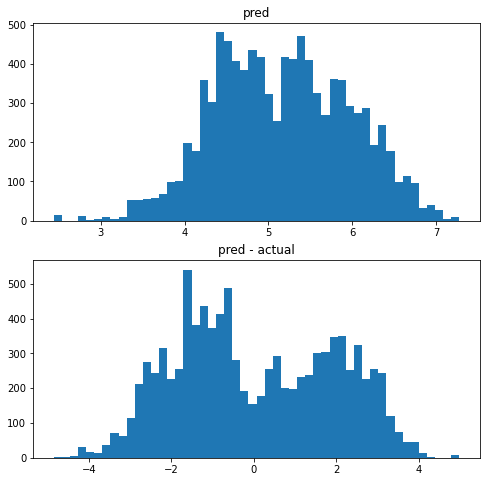

RMSE: 1.912706


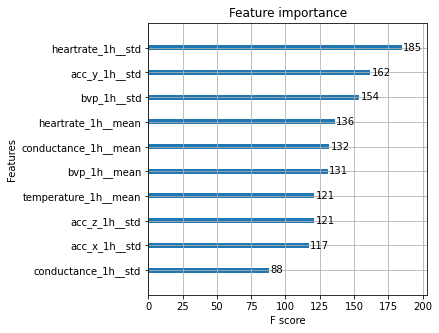

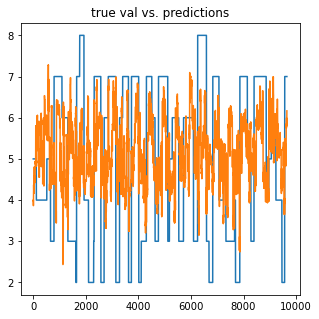

In [90]:
XGBRegressorForSurveyFast(train, test,'tired' ,testRatio = 0.2)

[0]	Yes-rmse:4.10338
[50]	Yes-rmse:2.05743
[84]	Yes-rmse:2.06263


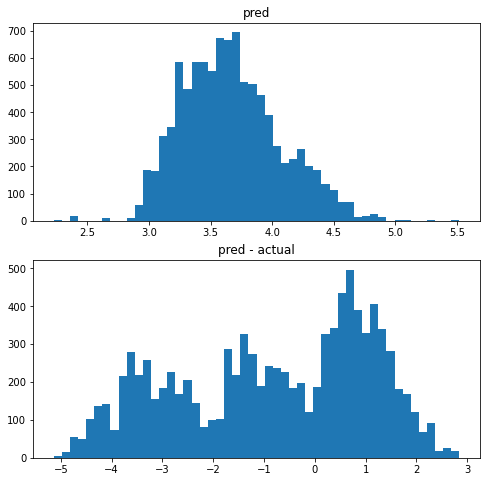

RMSE: 2.062448


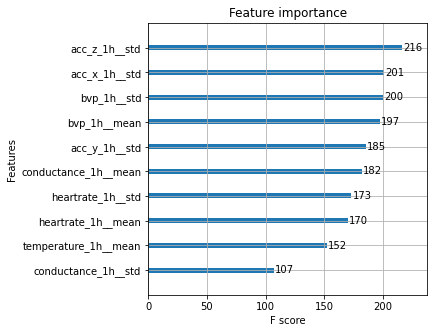

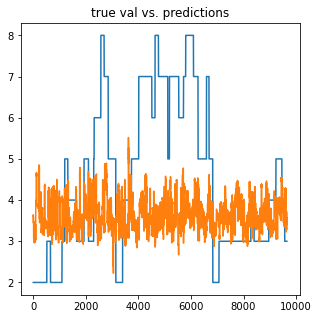

In [91]:
XGBRegressorForSurveyFast(train,test, 'anxious' ,testRatio = 0.2)

[0]	Yes-rmse:2.05785
[50]	Yes-rmse:0.97482
[77]	Yes-rmse:0.99277


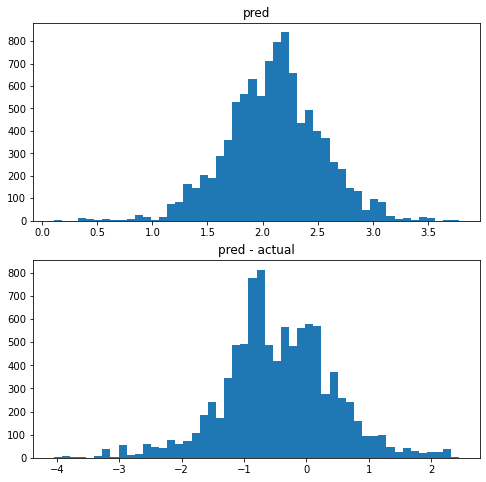

RMSE: 0.993002


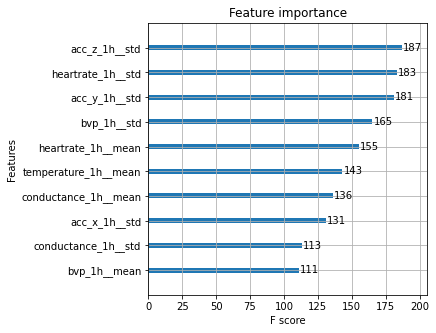

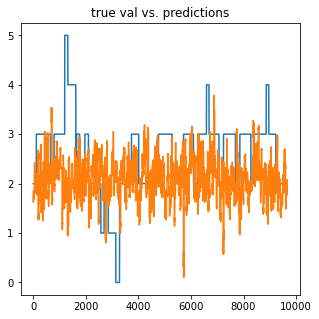

In [95]:
XGBRegressorForSurveyFast(train,test, 'sad' ,testRatio = 0.2)